In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from numpy.random import randn
from scipy.linalg import inv

# Kalman Filter

Kalman filter is a bayesian filter used to approximate system state using given measurements and process model. Below I will implement Kalman filter for multivariable system and demonstrate its results. Next step is to improve Kalman filter by implementing dynamic calculation of process noise during filters operation in order to improve its precision

## Research Process Description

In order to show results of the research, following plan was developed:
1. Develop a model with several variables, such as train movement.
2. Create imprecise measurements of the model, in order to use filter on
3. Show performance of a classic Kalman Filter on the model and measurements
4. Design Kalman filter with uses an agent to calculate process and sensor error as the filtering is in process
5. Show differences in performance of the filters - accuracy, speed, memory usage

## Model Under Study

As an example we will use train for which we have a location sensor. We will estimate speed and location as variables for our model.

## Kalman Filter Overview

![kalman](img/kalman-2.png)

In principle kalman filter has two stages prediction and update. During prediction we compute _prior_ which is the estimation of the next state of the system. During update step we incorporate measurements and select value of the system somewhere between prediction and measurement based on _Kalman gain_.

Below we will see how these stages are described and how we implement them.

## Kalman Filter Algorithm

**Initialization**

    1. Initialize the state of the filter
    2. Initialize initial state of the system
    
**Predict**

    1. Use process model to predict state at the next time step
    2. Adjust belief to account for the uncertainty in prediction    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute residual between estimated state and measurement
    3. Compute scaling factor based on whether the measurement
    or prediction is more accurate
    4. set state between the prediction and measurement based 
    on scaling factor
    5. update belief in the state based on how certain we are 
    in the measurement

## Variables in Kalman Filter

Now let's describe all variables we need for a Kalman filter:

$\mathbf{x}$ - state vector, when we talk about state, we always assume mean value, since we are never sure.

$\mathbf{P}$ - covariance matrix of our state.

$\mathbf{F}$ - state transition function.

$\mathbf{Q}$ - process covariance, this is uncertainty you have about your model calculations.

$\mathbf{B}$ - input function, transformation of an input vector corresponding to a model.

$\mathbf{u}$ - input vector.

$\mathbf{H}$ - measurement function.

$\mathbf{z}$ - measurement mean, basically value we get from the sensor.

$\mathbf{R}$ - measurement covariance matrix, how our measurement can deviate from the real value

$\mathbf{K}$ - Kalman gain, or how much we trust either measurement or prediction

$\mathbf{y}$ - residual

## Equations

Kalman filter is described by the following equations:

### Prediction

$\bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}$

$\bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q$

### Update

$\mathbf y = \mathbf z - \mathbf{H\bar x}$

$\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1}$

$ \mathbf x = \bar{\mathbf x} + \mathbf{Ky}$

$\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}}$

## Simulation for testing

For testing purposes we need to generate simulation. In our case it is movement of a train. We need to generate measurement with some deviation, as well as our prediction with some process deviation. We will have length of the simulation as a parameter and make samples every second. System will have initial position in form of a vector - first value is initial coordinate, second is initial speed. Each iteration we will change coordinate by speed + process noise. Also when we take measurements, sensor noise will be added. Function will return two vectors - vector of predicted coordinates and vector of measured coordinates.

In [2]:

def generate_simulation(initial_state, process_var, sensor_var, length=1):
    x = initial_state[0]
    v = initial_state[1]
    
    process_std = math.sqrt(process_var)
    sensor_std = math.sqrt(sensor_var)
    
    coordinates, measurements = [], []
    
    for _ in range(length):
        x += v + randn() * process_std # compute new coordinate
        coordinates.append(np.array([[x], [v]]))
        measurements.append(np.array([[x + randn() * sensor_std], [v + randn() * sensor_std]])) #compute sensor readings
    
    return np.array(coordinates), np.array(measurements)
        

## Visualizing Simulation

Now let's see how results of our simulation look like.

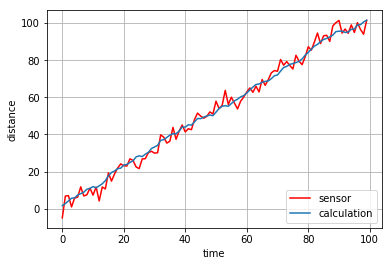

In [3]:
sim_length = 100
x, m = generate_simulation([0, 1], process_var=0.5, sensor_var=10.0, length=sim_length)

plt.plot(range(sim_length), m[:, 0] ,'r', label="sensor")
plt.plot(range(sim_length), x[:, 0], label="calculation")

plt.ylabel("distance")
plt.xlabel("time")
plt.legend(loc='lower right', shadow=False)
plt.grid(True)
plt.show()

## Implementation of Kalman Filter

To produce Kalman filter, we need to write two functions - predict and update You will see their code below.

## Predict function

As we already have seen above, prediction function consists of the follwing equations:

$\bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}$

$\bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q$

Prediction is used to compute prior - what we _predict_ will be the next state of the system. State of the system consists of mean of its variables and their covariance matrix.

In [4]:
def predict(x, P, F, Q, B=0, u=0):
    nx = np.dot(F, x) + np.dot(B, u)
    nP = np.dot(F, P).dot(F.T) + Q
    return nx, nP

## Update Function

Update function consists of the following equations:

$\mathbf y = \mathbf z - \mathbf{H\bar x}$

$\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1}$

$ \mathbf x = \bar{\mathbf x} + \mathbf{Ky}$

$\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}}$

This function is used to choose middlepoint between our prediction and measurement.

In [5]:
def update(H, P, R, x, z):
    y = z - np.dot(H, x)
    A = inv(np.dot(H, P).dot(H.T) + R)
    K = np.dot(P, H.T).dot(A)
    nx = x + np.dot(K, y)
    nP = P - np.dot(K, H).dot(P)
    
    return nx, nP

## Kalman Filter

Using functions defined above, let's write Kalman Filter.

In [6]:
def kalman(x, P, measures, R, Q, F, H, B=0, u=0):
    xs, cov = [], []
    for z in measures:
        # predict
        x = np.dot(F, x)
        P = np.dot(F, P).dot(F.T) + Q

        #update
        S = np.dot(H, P).dot(H.T) + R
        K = np.dot(P, H.T).dot(inv(S))
        print(K.shape)
        y = z - np.dot(H, x)
        x += np.dot(K, y)

        P = P - np.dot(K, H).dot(P)

        xs.append(x)
        cov.append(P)
    return np.array(xs), np.array(cov)

    

## Parameters for our example

(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)


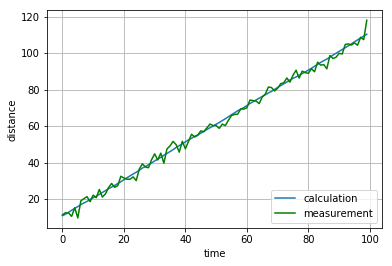

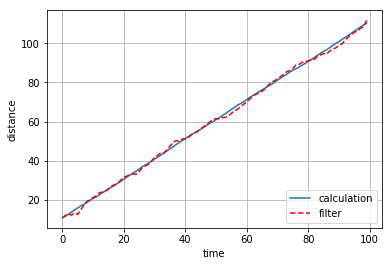

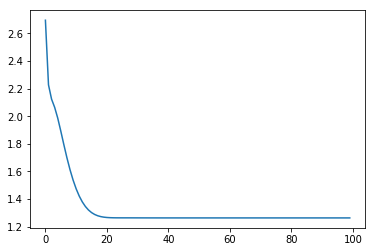

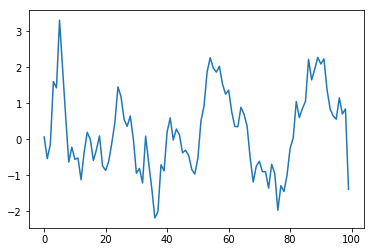

array([[ 10.],
       [  1.]])

In [8]:
sim_length = 100
x = np.array([[10., 1]]).T
P = np.diag([5., 1.])
F = np.array([[1., 1],
             [0., 1]])
R = np.array([[5., 0], [0, 5.]])
Q = np.array([[.01, 0.0],
              [0., .01]])
H = np.array([[1., 0], [0., 1.]])

xs, m = generate_simulation([10., 1], process_var=.01, sensor_var=5., length=sim_length)

fx, fP = kalman(x, P, m, R, Q, F, H)

plt.plot(range(sim_length), xs[:, 0], label="calculation")
plt.plot(range(sim_length), m[:, 0] ,'g', label="measurement")
plt.ylabel("distance")
plt.xlabel("time")
plt.legend(loc='lower right', shadow=False)
plt.grid(True)
plt.show()

plt.plot(range(sim_length), xs[:, 0], label="calculation")
plt.plot(range(sim_length), fx[:, 0], 'r--', label="filter")
plt.ylabel("distance")
plt.xlabel("time")
plt.legend(loc='lower right', shadow=False)
plt.grid(True)
plt.show()

plt.plot(range(sim_length), fP[:, 0, 0])
plt.show()

# print(fx[:, 0])
# print(xs - fx[:, 0])
plt.plot(range(sim_length), xs[:, 0].flatten() - fx[:, 0].flatten())
plt.show()
x

# Kalman Filter Improvement

Major problem of the Kalman filter is that its performance depends a lot on proper estimation of process and noise covariance matrices Q & R. In practice these parameters are hard to estimate correctly, so filter has sub-optimal performance.

In order to fix that, one of the proposals is to use neural network to correct kalman filter estimation.

Network accepts $K$ and $y$ of the filter as the input and produces state correction $X_{mod}$, which is used to adjust state calculated by the filter.

This idea is based on an article "Kalman Filtering Compensated by Radial Basis Function Neural Network for Seam Tracking of Laser Welding" (link below), which uses that technique to successfully improve Kalman Filter for Laser Welding process.

# Training Dataset

In [9]:
def kalman_training(x, P, measures, R, Q, F, H, B=0, u=0):
    xs, cov = [], []
    ys, Ks = [], []
    for z in measures:
        # predict
        x = np.dot(F, x)
        P = np.dot(F, P).dot(F.T) + Q

        #update
        S = np.dot(H, P).dot(H.T) + R
        K = np.dot(P, H.T).dot(inv(S))
        Ks.append(K.dot(np.array([[1], [0]])))
        y = z - np.dot(H, x)
        
        ys.append(y)
        x += np.dot(K, y)
        P = P - np.dot(K, H).dot(P)
        
        xs.append(x)
        cov.append(P)
    return np.array(xs), np.array(cov), np.array(ys), np.array(Ks)


sim_length = 1000
x = np.array([[10., 1]]).T
P = np.diag([5., 1.])
F = np.array([[1., 1],
             [0., 1]])
R = np.array([[5., 0], [0, 5.]])
Q = np.array([[.01, 0.0],
              [0., .01]])
H = np.array([[1., 0], [0., 1.]])



# Generating Test Data

We run simulation l times for each sample until we reach a sample size specified below.

In [11]:
import tqdm
l = 1000  # Sample length
N = 500 # Sample amount
h1 = 50 # Number of neurons

output_corr = []
input_set = []

for j in tqdm.tqdm(range(N)):
    sim_length = 1000
    x = np.array([[10., 1]]).T
    P = np.diag([5., 1.])
    F = np.array([[1., 1],
                 [0., 1]])
    R = np.array([[3., 0], [0, 3.]])
    Q = np.array([[.01, 0.0],
                  [0., .01]])
    H = np.array([[1., 0], [0., 1.]])
    xs, m = generate_simulation([10., 1], process_var=.01, sensor_var=3., length=sim_length)

    fx, fP, Zs, Ks = kalman_training(x, P, m, R, Q, F, H)

    correction = fx - xs
    output_corr.append(correction.squeeze())
    
    inp = np.column_stack((Zs.squeeze(), Ks.squeeze()))
    inp = np.array([inp for i in range(h1)])
    input_set.append(inp)


output_corr = np.array(output_corr)
input_set = np.array(input_set)


 28%|██▊       | 142/500 [00:10<00:25, 14.20it/s]/Users/nick/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 500/500 [00:37<00:00, 13.21it/s]


# Neural Network Parameters

Below we use information from the article to create our neural network.

In [12]:
x = tf.placeholder(tf.float64, (N, h1, l, 4), name="x")
y = tf.placeholder(tf.float64, (N, l, 2), name="y")
W = tf.Variable(initial_value=np.random.randn(1, h1, l, 4))
b = tf.Variable(initial_value=np.random.randn(1, l, 1))
n = tf.exp(-tf.square(tf.norm(W - x, axis=1) * b))
n = tf.reshape(n, (N, l, 2, 2))
W2 = tf.Variable(initial_value=np.random.randn(1, l, 2))

b2 = tf.Variable(initial_value=np.random.randn(1))
out1 = tf.reduce_sum(W2*n[:,:,:,0], axis=2)
out2 = tf.reduce_sum(W2*n[:,:,:,1], axis=2)

out = tf.stack([out1, out2], axis = 2) + b2
loss = tf.norm(y - out, ord=1)

sgd = tf.train.RMSPropOptimizer(0.01)   # Learning rate
step = sgd.minimize(loss)

# Train the Network

We train the network trying to minimize loss

In [ ]:
epochs = 1000
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run([init])

for i in range(epochs):
    loss_, _ = sess.run([loss, step], feed_dict={x: input_set, y: output_corr})
    print(str(i) + ": " + str(loss_))

0: 591035.653106
1: 549731.882457
2: 522906.728771
3: 503582.957777
4: 488748.033239
5: 476967.481459
6: 467174.784179
7: 458819.972324
8: 451535.443752
9: 445035.547035
10: 439126.532735
11: 433739.984486
12: 428818.486771
13: 424286.656795
14: 420084.377217
15: 416194.248795
16: 412611.938753
17: 409301.927858
18: 406266.895894
19: 403471.498664
20: 400924.678517
21: 398605.56388
22: 396511.620445
23: 394627.693255
24: 392950.740841
25: 391451.555363
26: 390128.13236
27: 388956.01068
28: 387930.507074
29: 387038.09779
30: 386272.819012
31: 385618.032477
32: 385060.307688
33: 384594.952936
34: 384206.563997
35: 383888.055959
36: 383626.334888
37: 383416.973692
38: 383246.15842
39: 383111.846082
40: 383005.369447
41: 382918.568282
42: 382851.005882
43: 382804.110335
44: 382758.811399
45: 382724.679157
46: 382693.452271
47: 382670.361672
48: 382652.66863
49: 382636.53439
50: 382624.751275
51: 382613.051332
52: 382604.840244
53: 382596.349349
54: 382595.166754
55: 382583.348514
56: 38257

# Results

If you run the training code above, you will notice that the loss is quite huge and not at all acceptable. This means that the network has failed to train on a given test data. 

I was not able to repeat experiment result of the article, which is due to several issues.
First of all, neural network was poorly described in the article, which makes it hard to infer its configuration. I lack experience in this domain (machine learning), so to analyze what went wrong and where is hard as it requires a lot of expert knowledge.

Secondly, paper describes concrete process and concrete solution to predict that process more accurately. I do not see why the algorithm proposed cannot be used in general sense, but again, lack of expert knowledge leaves ma unsure.

Quality of the paper leaves more to be desired. Notation is inconsitent and there are a lot of grammatical mistakes which makes it hard to understand what the authors meant. Also authors leave a lot of details out of the paper, such as the size of the training dataset, initial parameters, etc.

Given more time and knowledge, this research has a great potential to enhance classic filtering algorithms, however I was not able to repeat the success of the authors

# References

https://ieeexplore.ieee.org/document/6353188/ - paper the research is based on